# Análisis de uso de Hashtags en el texto de los tweets.

En este notebook vamos a realizar un análisis sobre el uso de hashtags en cada Tweet.

La idea principal es ver si existe alguna relación entre estos y la veracidad de los tweets.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
def countplot(df_data, column, title):
    fig_size = (10,6)
    fig, ax = plt.subplots(figsize=fig_size)

    sns.countplot(x=column, data=df_data)
    plt.title(title)
    plt.show()

In [3]:
df = pd.read_csv("../dataset/train.csv", encoding='utf-8', usecols=['text', 'target'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
text      7613 non-null object
target    7613 non-null int64
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [5]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Obtención de hashtags

A continuación crearemos dos columnas:

* hashtags: Esta columna tendrá como valor una lista con los hashtags utilizados en el tweet.
* cantidad: Esta columna tendrá como valor la cantidad de hashtags encontrados en el tweet.

Luego obtendremos algunas estadísticas sobre la cantidad de hashtags y veremos la distribución de hashtags utilizados.

In [6]:
df['hashtags'] = df['text'].str.findall(r'#.*?(?=\s|$)')
df['hashtags'] = df['hashtags'].map(lambda x: [word.lower().replace('#', '') for word in x])
df['cantidad_hashtags'] = df['hashtags'].apply(len)
df = df[['hashtags', 'cantidad_hashtags', 'target']]

In [7]:
df.head()

,hashtags,cantidad_hashtags,target
0,[earthquake],1,1
1,[],0,1
2,[],0,1
3,[wildfires],1,1
4,"[alaska, wildfires]",2,1


In [8]:
df['cantidad_hashtags'].describe()

count    7613.000000
mean        0.444503
std         1.095049
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: cantidad_hashtags, dtype: float64

Algunas observaciones:

* Viendo el promedio, y los cuantiles 25/50/75 podemos observar que la mayoría de los tweets no poseen hashtags.
* La cantidad máxima de hashtags observados en un tweet es 13.

Vamos a visualizar estos resultados utilizando un gráfico de barras.

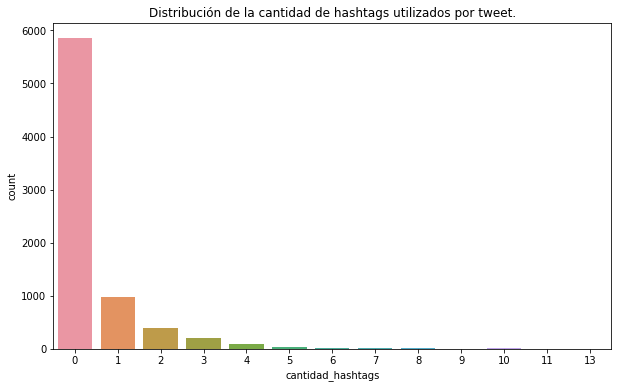

In [9]:
countplot(df, 'cantidad_hashtags', 'Distribución de la cantidad de hashtags utilizados por tweet.')

## Veracidad de tweets en relación a la presencia de hashtags.

En esta sección veremos si hay alguna relación entre la veracidad de los tweets y el uso de hashtags en los mismos.

Para eso vamos a crear una nueva columna que nos indique si el tweet posee o no al menos un hashtag.

Luego observaremos qué porcentaje de aquellos que tengan hashtags son verdaderos, y lo mismo para los tweets que no poseen hashtags.

In [10]:
tiene_hashtags = df['cantidad_hashtags'] > 0
df.insert(loc=df.columns.get_loc('target'), column='tiene_hashtags', value=tiene_hashtags)
df.head()

,hashtags,cantidad_hashtags,tiene_hashtags,target
0,[earthquake],1,True,1
1,[],0,False,1
2,[],0,False,1
3,[wildfires],1,True,1
4,"[alaska, wildfires]",2,True,1


In [11]:
con_hashtag = df[df['tiene_hashtags'] == True]['target'].value_counts()
sin_hashtag = df[df['tiene_hashtags'] == False]['target'].value_counts()

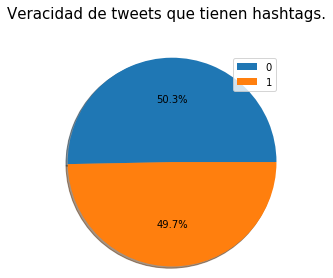

In [12]:
plt.pie(con_hashtag, autopct='%1.1f%%',shadow=True, radius=1.2)
plt.legend(con_hashtag.index.to_list())
plt.figtext(0.5, 1.0, 'Veracidad de tweets que tienen hashtags.', fontsize=15, ha='center')
plt.show()

Podemos ver que en presencia de hashtags, la veracidad de los tweets es pareja.

Veamos qué sucede en el caso de aquellos tweets que no poseen hashtags en su texto.

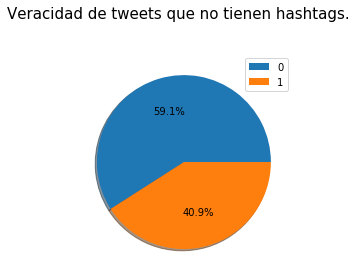

In [13]:
plt.pie(sin_hashtag, autopct='%1.1f%%',shadow=True)
plt.legend(sin_hashtag.index.to_list())
plt.figtext(0.5, 1.0, 'Veracidad de tweets que no tienen hashtags.', fontsize=15, ha='center')
plt.show()

En este caso notamos que el 59.1% de los tweets sin hashtag son falsos, mientras que el 40.9% restante son verdaderos.

Esto podría indicar que la ausencia de hashtags influencia la veracidad de los tweets. Podría ser un feature útil para el siguiente trabajo práctico.

## Tweets reales vs falsos

En esta sección haremos el mismo análisis inicial pero diviendo el dataframe en dos partes de acuerdo a la veracidad de cada tweet.

In [14]:
df_real = df[df['target'] == 1]
df_falso = df[df['target'] == 0]

In [15]:
df_real['cantidad_hashtags'].value_counts(normalize=True)

0     0.732498
1     0.148884
2     0.061449
3     0.029655
4     0.011923
5     0.006726
10    0.002140
8     0.002140
6     0.002140
13    0.001223
7     0.001223
Name: cantidad_hashtags, dtype: float64

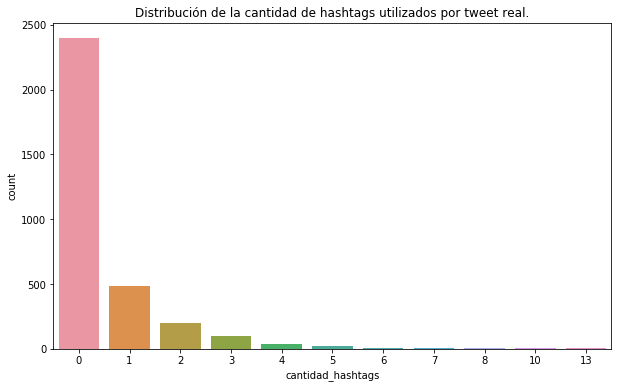

In [16]:
countplot(df_real, 'cantidad_hashtags', 'Distribución de la cantidad de hashtags utilizados por tweet real.')

In [17]:
df_falso['cantidad_hashtags'].value_counts(normalize=True)

0     0.795947
1     0.111930
2     0.046062
3     0.024643
4     0.010594
6     0.004146
5     0.003915
7     0.000921
10    0.000691
11    0.000461
9     0.000461
8     0.000230
Name: cantidad_hashtags, dtype: float64

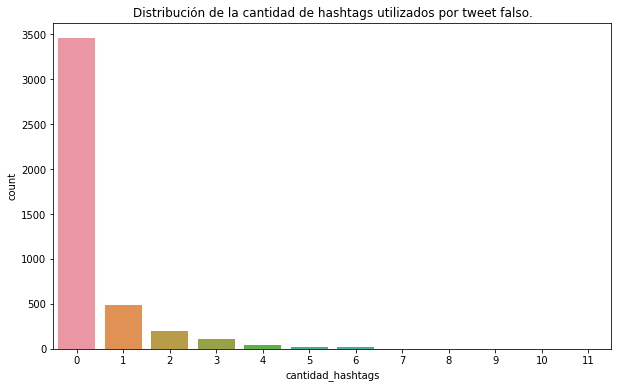

In [18]:
countplot(df_falso, 'cantidad_hashtags', 'Distribución de la cantidad de hashtags utilizados por tweet falso.')

No se observa algo de interés, la distribución es similar a la del total de los tweets tanto en el caso de los reales como de los falsos.

# Hashtags más usados en Tweets Reales.

Adicionalmente nos interesaría visualizar cuáles son los hashtags más frecuentes en los tweets Reales, por lo que veremos un top 10 de los mismos y luego un WordCloud sobre el top 25.

In [19]:
hashtags = df_real['hashtags'].explode().dropna()
hashtags.value_counts().head(10)

news          53
???           23
hiroshima     21
??            19
earthquake    19
best          13
prebreak      13
hot           13
japan         11
india         10
Name: hashtags, dtype: int64

In [20]:
text = ' '.join(hashtags.values)

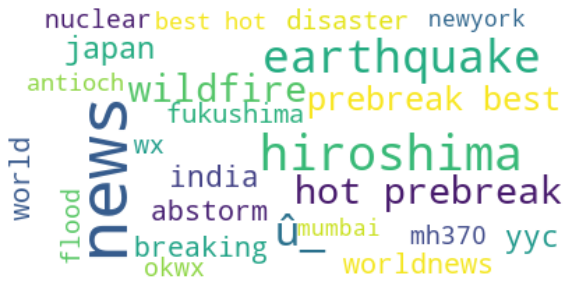

In [21]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='white').generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()